In [22]:
from pathlib import Path
import numpy as np
import torch as pt
import nibabel as nb
import nitools as nt
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import Functional_Fusion.atlas_map as am
import Functional_Fusion.dataset as ds
import HierarchBayesParcel.arrangements as ar
import HierarchBayesParcel.emissions as em
import HierarchBayesParcel.full_model as fm
import FusionModel.evaluate as ev
import FusionModel.util as futil
import scripts.paths as paths
import scipy


In [2]:
base_dir = paths.set_base_dir()
atlas_dir = paths.set_atlas_dir(base_dir)
figure_dir = paths.set_figure_dir()
model_dir = paths.set_model_dir(base_dir)
export_dir = paths.set_export_dir(base_dir)
fusion_dir = paths.set_fusion_dir(base_dir)
atlas_paper_figure_dir = '/Users/callithrix/Dropbox (Personal)/AtlasPaper/Figure_parts/'

# Set plot context and style
sb.set_context('poster')

In [3]:
def make_eval_info(M, train_info=None, tdata='MDTB',
                   group_type='Models_03', indivtrain_ind='half',
                   indivtrain_values=1, indivtest_values=2,
                   test_kappa=None):
    """ Collects all the information from the model and the
        training and test data sets into a single dictionary

    Args:
        M (fm.Model): model object
        train_info (dict): training data information
        test_info (dict): test data information

    Returns:
        minfo (dict): model information
    """
    if train_info is None:
        train_info = pd.Series()
    minfo = train_info
    minfo['test_data'] = tdata
    minfo['group_type'] = group_type
    minfo['indivtrain_ind'] = indivtrain_ind
    minfo['indivtrain_val'] = indivtrain_values
    minfo['indivtest_val'] = indivtest_values
    # minfo['indiv_train_kappa'] = M.emissions[0].uniform_kappa
    # minfo['indiv_test_kappa'] = test_kappa
    return minfo

def eval_parcel_DCBC(U_group, U_indiv, t_data, dist, minfo, out_file=None):
    # convert tdata to tensor
    if type(t_data) is np.ndarray:
        t_data = pt.tensor(t_data, dtype=pt.get_default_dtype())
    # convert U_group and U_indiv to tensor
    if type(U_group) is np.ndarray:
        U_group = pt.tensor(U_group, dtype=pt.get_default_dtype())
    if type(U_indiv) is np.ndarray:
        U_indiv = pt.tensor(U_indiv, dtype=pt.get_default_dtype())

    num_subj = t_data.shape[0]
    # Now run the DCBC evaluation fo the group
    Pgroup = pt.argmax(U_group, dim=0) + 1
    Pindiv = pt.argmax(U_indiv, dim=1) + 1
    dcbc_group = ev.calc_test_dcbc(Pgroup, t_data, dist)
    dcbc_indiv = ev.calc_test_dcbc(Pindiv, t_data, dist)

    # ------------------------------------------
    # Collect the information from the evaluation
    # in a data frame
    train_datasets = minfo.datasets
    if isinstance(minfo.datasets, pd.Series):
        train_datasets = minfo.datasets.tolist()
    ev_df = pd.DataFrame({'model_name': [minfo['name']] * num_subj,
                          'atlas': [minfo.atlas] * num_subj,
                          'K': [minfo.K] * num_subj,
                          'train_data': [train_datasets] * num_subj,
                          'train_loglik': [minfo.loglik] * num_subj,
                          'test_data': [minfo.test_data] * num_subj,
                          'group_type': [minfo.group_type] * num_subj,
                          'indivtrain_ind': [minfo.indivtrain_ind] * num_subj,
                          'indivtrain_val': [minfo.indivtrain_val] * num_subj,
                          'indivtest_val': [minfo.indivtest_val] * num_subj,
                          'subj_num': np.arange(num_subj),
                        #   'indiv_train_kappa': [minfo.indiv_train_kappa] * num_subj,
                        #   'indiv_test_kappa': [minfo.indiv_test_kappa] * num_subj
                          })
    # Add all the evaluations to the data frame
    ev_df['dcbc_group'] = dcbc_group.cpu()
    ev_df['dcbc_indiv'] = dcbc_indiv.cpu()
    ev_df.to_csv(out_file, index=False, sep='\t')
    return ev_df

def plot_multi_flat(data, atlas, grid, cmap='tab20b', dtype='label',
                    cscale=None, titles=None, colorbar=False,
                    save_fig=False):
    """ Plot multiple flatmaps in a grid

    Args:
        data: the input parcellations, shape(N, K, P) where N indicates
              the number of parcellations, K indicates the number of
              parcels, and P is the number of vertices.
        atlas: the atlas name used to plot the flatmap
        grid: the grid shape of the subplots
        cmap: the colormap used to plot the flatmap
        dtype: the data type of the input data, 'label' or 'prob'
        cscale: the color scale used to plot the flatmap
        titles: the titles of the subplots
        colorbar: whether to plot the colorbar
        save_fig: whether to save the figure, default format is png

    Returns:
        The plt figure plot
    """

    if isinstance(data, np.ndarray):
        n_subplots = data.shape[0]
    elif isinstance(data, list):
        n_subplots = len(data)

    if not isinstance(cmap, list):
        cmap = [cmap] * n_subplots

    for i in np.arange(n_subplots):
        plt.subplot(grid[0], grid[1], i + 1)
        futil.plot_data_flat(data[i], atlas,
                       cmap=cmap[i],
                       dtype=dtype,
                       cscale=None,
                       render='matplotlib',
                       colorbar=(i == 0) & colorbar)

        plt.title(titles[i])
        plt.tight_layout()

    if save_fig:
        plt.savefig('/indiv_parcellations.png')

In [4]:
space, _ = am.get_atlas('MNISymC2')
if space.name == 'MNISymC2':
    space_folder = 'tpl-MNI152NLin2009cSymC'


# Load group prior and construct arrangement model
sym_type = 'sym'
atlas = 'NettekovenSym32'
model_name = f'/{space_folder}/atl-{atlas}_space-{space_folder.split("tpl-")[1]}_probseg.nii'
_, cmap, labels = nt.read_lut(f'{atlas_dir}/{space_folder}/atl-{atlas}.lut')
U = space.read_data(atlas_dir + model_name)
U = U.T
ar_model = ar.build_arrangement_model(U, prior_type='prob', sym_type=sym_type, atlas=space)


/Users/callithrix/code/Python/HierarchBayesParcel/arrangements.py:1941: UserWarning: The marginal probability has 18207 voxels zero values - adding small value to avoid -inf
  warnings.warn(f'The marginal probability has {zero_voxl} voxels'


In [5]:
# Step 4b.1: Load the data into 3d tensor
data, info, tds = ds.get_dataset(fusion_dir, 'Language', atlas=space.name, subj=['sub-01','sub-02','sub-03','sub-04','sub-06','sub-07','sub-08'], type= 'CondRun',sess='ses-localizer_cond')

# Step 4b.2: Prepare the data into the right format
tdata, cond_v, part_v, sub_ind = fm.prep_datasets(data, info.sess,
                                                  info['reg_id'].values,
                                                  info['run'].values,
                                                  join_sess=False,
                                                  join_sess_part=False)



In [ ]:
data_train = tdata[0][:,:68,:]
data_eval = tdata[0][:,68:,:]

cond_v_train = cond_v[0][:68]
cond_v_eval = cond_v[0][68:]

part_v_train = part_v[0][:68]
part_v_eval = part_v[0][:68]

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


In [7]:
Vs = None
em_models = []
for j , this_cv in enumerate([cond_v_train]):
    if sym_type == 'sym':
        K = ar_model.K_full

    else:
        K = ar_model.K

    x_matrix  = fm.indicator(this_cv)
    em_model = em.MixVMF(K = K , P = space.P, X = x_matrix, part_vec=part_v_train,subject_specific_kappa= False,parcel_specific_kappa= False,subjects_equal_weight= True)
    em_models.append(em_model)
# build full model (arang +emiss)
M = fm.FullMultiModel(arrange=ar_model,emission=em_models)
M.initialize([data_train], subj_ind= sub_ind)
# em algo
M, ll,_,U_individual = M.fit_em(iter=200, tol=0.01,
                                     fit_arrangement=False,
                                     fit_emission= True,
                                     first_evidence=False)

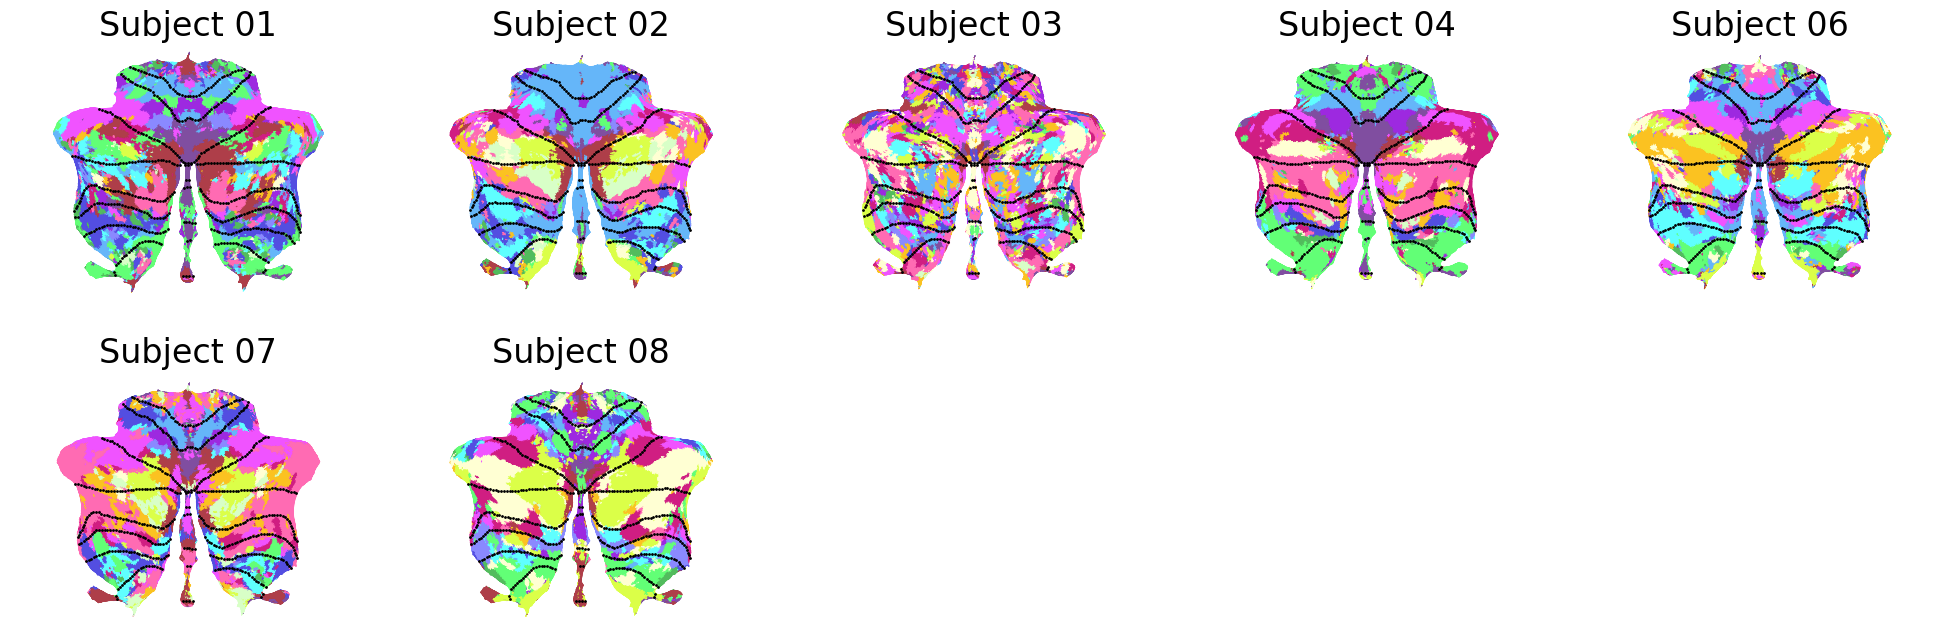

In [23]:
T = pd.read_csv(f'{fusion_dir}/Language/participants.tsv', delimiter='\t')
all_participants = ['Subject 01','Subject 02','Subject 03','Subject 04','Subject 06','Subject 07','Subject 08']

plt.figure(figsize=(20,20))
plot_multi_flat(U_individual.cpu().numpy(), atlas=space.name, grid=(6, 5),
                cmap=cmap, dtype='prob',
                titles=all_participants)
plt.savefig(f'{atlas_paper_figure_dir}/replication_dataset_indiv_parcellations.png')

# eval

In [9]:
_, minfo = ar.load_group_parcellation(f'{model_dir}/Models_03/NettekovenSym32_space-MNISymC2', device='cpu')

dist = ev.compute_dist(space.world.T, resolution=1)
eval_info = make_eval_info(M, minfo, tdata='Langloc', group_type='Models_03',
                               indivtrain_ind='run', indivtrain_values=1,
                               indivtest_values=2, test_kappa=None)

In [10]:
ev_lang = eval_parcel_DCBC(U, U_individual, data_eval, dist, eval_info,
                     out_file='eval_dcbc_indiv_parcellations.tsv')

Subject 0:25.6735s
Subject 1:22.6545s
Subject 2:22.7320s
Subject 3:22.1758s
Subject 4:21.7562s
Subject 5:22.1915s
Subject 6:23.4591s
Subject 0:22.4740s
Subject 1:23.3838s
Subject 2:22.1662s
Subject 3:22.0560s
Subject 4:22.1035s
Subject 5:23.0520s
Subject 6:25.1245s


In [11]:
ev_lang.to_csv('eval_dcbc_indiv_parcellations_language.tsv', sep='\t')

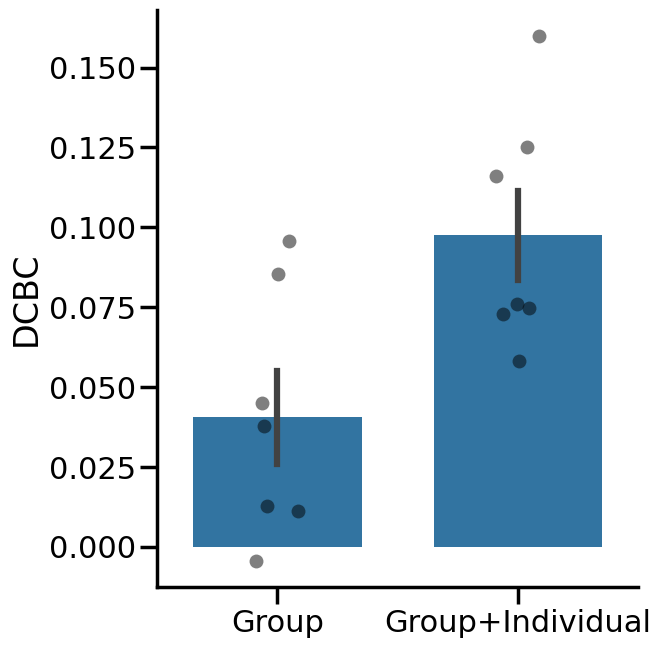

In [19]:
plt.figure(figsize=(7, 7))
df = pd.melt(ev_lang, var_name='group', value_name='value')
df = df.loc[(df['group'] == 'dcbc_group') | (df['group'] == 'dcbc_indiv')]
sb.barplot(x='group', y='value', errorbar="se", width=0.7, data=df)
sb.stripplot(x='group', y='value', data=df, color='black', alpha=0.5, size=10)
ax = plt.gca()  
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([0,1],['Group', 'Group+Individual'])
plt.ylabel('DCBC')
plt.xlabel('')
plt.tight_layout()
plt.savefig(f'{atlas_paper_figure_dir}/replication_dataset_dcbc_indiv_group.png')

## Stats

In [32]:
# Calculate stats
dcbc_group = ev_lang['dcbc_group'].values
dcbc_indiv = ev_lang['dcbc_indiv'].values
t, p = scipy.stats.ttest_rel(dcbc_group, dcbc_indiv)
# Print in scientific notation with degrees of freedom
degrees_of_freedom = len(dcbc_group) - 1
print(f't({degrees_of_freedom}) = {t:.2f}, p = {p:.2e}')


t(6) = -7.57, p = 2.76e-04
